<a href="https://colab.research.google.com/github/h5ng/influence_functions/blob/master/Time_Series_Classification_with_Kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
!pip install fastdtw

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import time


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [213]:
origin_X = scipy.io.loadmat('./Trace_half_data.mat')['data']
origin_Y = scipy.io.loadmat('./Trace_half_label.mat')['label'][0]

X, Y = [], []

for i in range(len(origin_Y)):
  if origin_Y[i] == 1 or origin_Y[i] == 4:
    #X.append(origin_X[i][45:80])
    X.append(origin_X[i])
    Y.append(origin_Y[i])

X = np.array(X)
Y = np.array(Y).reshape(-1, 1)
Y = np.where(Y == 4, -1, Y)

print(np.shape(X))
print(np.shape(Y))
print(Y)

(20, 275)
(20, 1)
[[-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]]


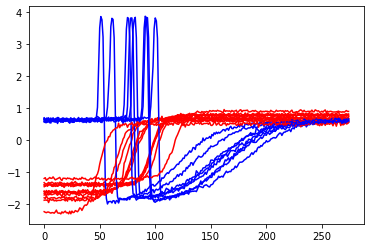

In [214]:
for i in range(len(X)):
  plt.plot(X[i].ravel(), 'b' if Y[i] == 1 else 'r')

plt.show()

In [215]:
batch_size = np.shape(X)[0]
#batch_size = 20

X_data = tf.placeholder(shape=[None, np.shape(X)[1]], dtype=tf.float32, name='X_data')
Y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='Y_target')
W = tf.Variable(tf.random_normal(shape=[1, batch_size]), name='weight')

prediction_grid = tf.placeholder(shape=[None, np.shape(X)[1]], dtype=tf.float32, name='prediction_grid')

print(X_data)
print(Y_target)
print(np.shape(Y.reshape(-1, 1)))
print(W)
print(prediction_grid)

Tensor("X_data_11:0", shape=(?, 275), dtype=float32)
Tensor("Y_target_11:0", shape=(?, 1), dtype=float32)
(20, 1)
<tf.Variable 'weight_11:0' shape=(1, 20) dtype=float32_ref>
Tensor("prediction_grid_11:0", shape=(?, 275), dtype=float32)


In [216]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i) 
    
  return dtw_array

# n = 10
# r = _dtw(X[:n], X[:n])
# print(np.shape(r))

$k_{GDTW}(x,z) = exp(-\gamma d_{DTW}(x,z))$

In [217]:
gamma = tf.constant(1.8)
dtw_distances = tf.py_function(func=_dtw, inp=[X_data, X_data], Tout=[tf.float32 for i in range(len(X))])

kernel = tf.exp(-tf.multiply(gamma, dtw_distances))

In [218]:
first_term = tf.reduce_sum(W)

w_vec_cross = tf.matmul(tf.transpose(W), W)
y_target_cross = tf.matmul(Y_target, tf.transpose(Y_target))
second_term = tf.reduce_sum(
    tf.multiply(kernel, tf.multiply(w_vec_cross, y_target_cross))
)
loss = tf.negative(tf.subtract(first_term, second_term))

In [219]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X_data, prediction_grid], Tout=[tf.float32 for i in range(len(X))])
pred_kernel = tf.exp(-tf.multiply(gamma, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y_target), W), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y_target)), tf.float32))

In [220]:
opt = tf.train.GradientDescentOptimizer(0.01)
train = opt.minimize(loss)
init = tf.initialize_all_variables()
#grad = tf.gradients(loss, )

sess = tf.Session()
sess.run(init)

In [221]:
start = time.time()

loss_vec = []
batch_accuracy = []
for i in range(20):
  local_start = time.time()
  rand_index = np.random.choice(len(X), size=batch_size)  
  rand_X = X[rand_index]
  rand_Y = Y[rand_index]

  sess.run(train, feed_dict={X_data: rand_X, Y_target: rand_Y})
  temp_loss = sess.run(loss, feed_dict={X_data: rand_X, Y_target: rand_Y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={X_data: rand_X, Y_target: rand_Y, prediction_grid: rand_X})
  batch_accuracy.append(acc_temp)

  #sess.run(train, feed_dict={X_data: X, Y_target: Y})
  #temp_loss = sess.run(loss, feed_dict={X_data: X, Y_target: Y})
  #loss_vec.append(temp_loss)

  #acc_temp = sess.run(accuracy, feed_dict={X_data: X, Y_target: Y, prediction_grid: X})
  #batch_accuracy.append(acc_temp)

  print("time :", time.time() - local_start)  # 현재시각 - 시작시간 = 실행 시간
  if (i + 1) % 10 == 0:
    print('Step #' + str(i+1))
    print('Loss = ' + str(temp_loss))

print("time :", time.time() - start)

time : 92.7465250492096
time : 92.24642181396484
time : 92.39649391174316
time : 92.67350935935974
time : 91.5910050868988
time : 91.88581490516663
time : 91.33751821517944
time : 92.12645030021667
time : 92.4025604724884
time : 91.79685306549072
Step #10
Loss = 8.690352
time : 91.94633030891418
time : 92.6865963935852
time : 92.45308423042297
time : 92.55970978736877
time : 92.37623500823975
time : 91.8885748386383
time : 92.6553053855896
time : 91.72180795669556
time : 92.14646077156067
time : 91.97773790359497
Step #20
Loss = 6.139718
time : 1843.6224353313446


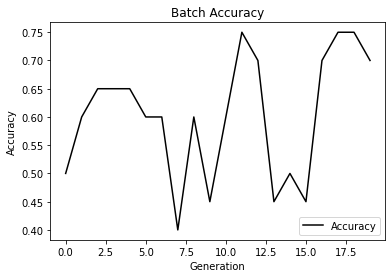

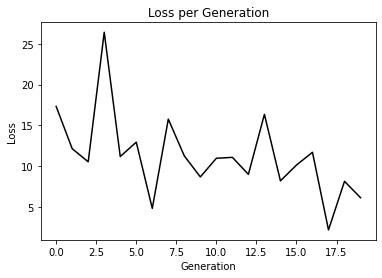

In [222]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [223]:
result = sess.run(prediction, feed_dict={X_data: X, Y_target: Y, prediction_grid: X})


In [224]:
result = np.squeeze(result)
_result = np.squeeze(Y)
for i in range(len(_result)):
  print(int(result[i]) == _result[i])

False
True
True
True
False
False
True
True
True
False
True
False
True
False
False
True
True
True
True
True


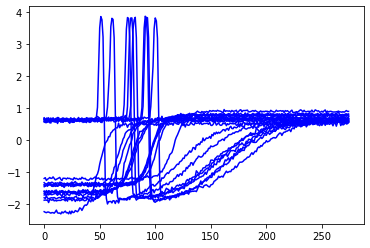

In [225]:
for i in range(len(X)):
  plt.plot(X[i].ravel(), 'b')
plt.show()

[ 0  2  4  5 10 11 12 16 19]


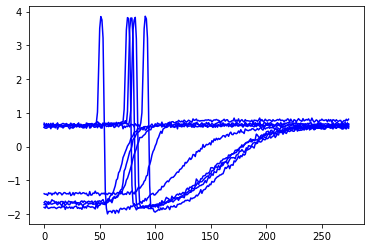

In [226]:
class1 = np.where(result == 1)[0]
print(class1)
for i in range(len(class1)):
  plt.plot(X[class1[i]].ravel(), 'b')

[ 1  3  6  7  8  9 13 14 15 17 18]


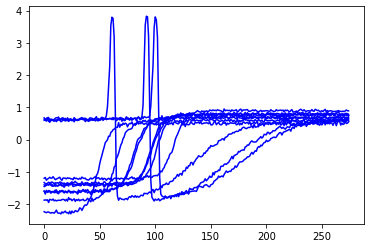

In [227]:
class2 = np.where(result == -1)[0]
print(class2)
for i in range(len(class2)):
  plt.plot(X[class2[i]].ravel(), 'b')

In [228]:
batch_accuracy

[0.5,
 0.6,
 0.65,
 0.65,
 0.65,
 0.6,
 0.6,
 0.4,
 0.6,
 0.45,
 0.6,
 0.75,
 0.7,
 0.45,
 0.5,
 0.45,
 0.7,
 0.75,
 0.75,
 0.7]